In [ ]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from corner import corner

from gigalens import *
from gigalens.profiles.light import *
from gigalens.profiles.mass import *

sns.set_style("whitegrid")
tfd = tfp.distributions

Load the data. The ground truth parameters are in `truth`. Various hyperparameters, including the noise scale and exposure time are fixed.

The PSF is generated from `TinyTim` for HST F140W band, and has been supersampled to the pixel scale of 0.065.

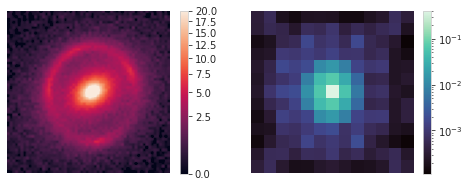

In [26]:
truth = [1.1, 2.0, 0.1, 0.1, 0.1, 0, -0.01, 0.03,
     0.8, 2.5, 0.09534746574143645, 0.14849487967198177, 0.1, 0, 499.3695906504067,
     0.25, 1.5, 0, 0, 0.09566681002252231, -0.0639623054267272, 149.58828877085668
]

background_rms = 0.2
exp_time = 100
pixscale = 0.065
image_noisy, kernel = np.load('./assets/demo.npy'), np.load('./assets/psf.npy')
num_pix = len(image_noisy)

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(image_noisy, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20), origin='lower')
plt.colorbar()
plt.axis('off')
plt.subplot(122)
plt.imshow(kernel, norm=mpl.colors.LogNorm(), cmap='mako')
plt.axis('off')
plt.colorbar()

In [28]:
model.param_to_dict(truth)

([{'theta_E': 1.1,
   'gamma': 2.0,
   'e1': 0.1,
   'e2': 0.1,
   'center_x': 0.1,
   'center_y': 0},
  {'gamma1': -0.01, 'gamma2': 0.03}],
 [{'R_sersic': 0.8,
   'n_sersic': 2.5,
   'e1': 0.09534746574143645,
   'e2': 0.14849487967198177,
   'center_x': 0.1,
   'center_y': 0,
   'amp': 499.3695906504067}],
 [{'R_sersic': 0.25,
   'n_sersic': 1.5,
   'e1': 0,
   'e2': 0,
   'center_x': 0.09566681002252231,
   'center_y': -0.0639623054267272,
   'amp': 149.58828877085668}])

Specify the physical and probabilistic model. The physical model is comprised of an elliptical power law (EPL) + external shear. The lens and source light are both modeled as a Sersic ellipse.

In [3]:
epl = EPL(50)
epl.prior[0] = tfd.LogNormal(tf.math.log(1.25), 0.25) # Einstein radius
epl.prior[1] = tfd.TruncatedNormal(2, 0.25, 1, 3) # Mass profile slope
epl.prior[2] = tfd.Normal(0, 0.1) # e1
epl.prior[3] = tfd.Normal(0, 0.1) # e2
epl.prior[4] = tfd.Normal(0, 0.05) # x-center
epl.prior[5] = tfd.Normal(0, 0.05) # y-center

shear = Shear()
shear.prior[0] = tfd.Normal(0, 0.05) # gamma1
shear.prior[1] = tfd.Normal(0, 0.05) # gamma2

ll = SersicEllipse(use_lstsq=False)
ll.prior[0] = tfd.LogNormal(tf.math.log(1.0), 0.15) # Sersic radius
ll.prior[1] = tfd.Uniform(2, 6) # Sersic index
ll.prior[2] = tfd.TruncatedNormal(0, 0.1, -0.3, 0.3) # e1
ll.prior[3] = tfd.TruncatedNormal(0, 0.1, -0.3, 0.3) # e2
ll.prior[4] = tfd.Normal(0, 0.05) # x-center
ll.prior[5] = tfd.Normal(0, 0.05) # y-center
ll.prior[6] = tfd.LogNormal(tf.math.log(500.), 0.3) # Amplitude

src = SersicEllipse(use_lstsq=False)
src.prior[0] = tfd.LogNormal(tf.math.log(0.25), 0.15) # Sersic radius
src.prior[1] = tfd.Uniform(0.5, 4) # Sersic index
src.prior[2] = tfd.TruncatedNormal(0, 0.15, -0.5, 0.5) # e1
src.prior[3] = tfd.TruncatedNormal(0, 0.15, -0.5, 0.5) # e2
src.prior[4] = tfd.Normal(0, 0.25) # x-center
src.prior[5] = tfd.Normal(0, 0.25) # y-center
src.prior[6] = tfd.LogNormal(tf.math.log(150.), 0.5) # Amplitude

model = Model([epl, shear], [ll], [src])

2021-11-04 16:22:00.638255: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x56489ceb0cc0


Sanity check: calculate residuals using ground truth.

2021-11-04 16:22:01.811321: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-04 16:22:02.305932: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


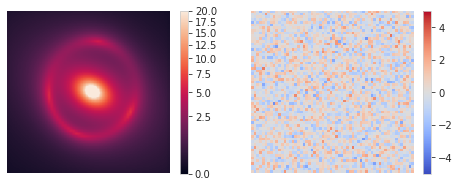

In [4]:
lensSim = LensSimulator(model, delta_pix=pixscale, num_pix=num_pix, kernel=kernel, supersample=2)

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(lensSim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)
plt.colorbar()
plt.axis('off')
plt.subplot(122)
simulated = lensSim.simulate(truth)
resid = simulated - image_noisy
err_map = np.sqrt(background_rms**2 + simulated/exp_time)
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-5, vmax=5)
plt.axis('off')
plt.colorbar()

Begin fitting. We use `supersample=1` for this demonstration to speed things up, but setting `supersample=2` is recommended in practice. This will not significantly slow down the fitting.

In [5]:
fitter = Fitter(model, delta_pix=pixscale, num_pix=num_pix, kernel=kernel, supersample=1, 
                observed_image=image_noisy, background_rms=background_rms, exp_time=exp_time)

In [6]:
MAP, hist = fitter.MAP(n_samples=500, num_steps=500, lr0=5e-2, seed=1, lr_reduce_factor=5)

  0%|          | 0/500 [00:00<?, ?it/s]

In [8]:
q_z, losses = fitter.SVI(MAP, n_vi=500, num_steps=2000, lr_increase=1e-3/150, lr_max=5e-3)

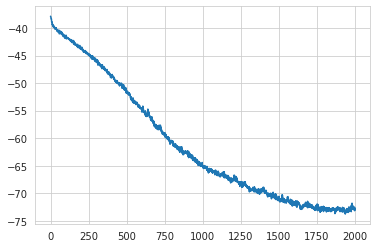

In [9]:
plt.plot(losses)

In [22]:
samples, sample_stats = fitter.HMC(q_z, n_hmc=50, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=250, num_results=750)

/global/homes/a/andigu/.local/perlmutter/tensorflow2.6.0/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


  0%|          | 0/999 [00:00<?, ?it/s]

In [23]:
physical_samples = model.bij.forward(samples)
Rhat = tfp.mcmc.potential_scale_reduction(physical_samples).numpy()
ESS = tfp.mcmc.effective_sample_size(physical_samples, cross_chain_dims=1).numpy()
print(Rhat)

[1.0011914 1.0037508 1.0021932 1.0021243 1.0006232 1.0011439 1.0027983
 1.002016  1.0003961 1.0004563 0.9999086 1.0004021 1.0004225 0.9998134
 1.0003103 1.0016855 1.0017042 1.0000561 1.0004051 1.000964  1.0031111
 1.0016418]


In [24]:
print(ESS)

[23368.762 12072.467 18562.727 19020.111 27202.594 25812.652 14821.105
 18660.428 28130.268 28764.623 27313.992 26657.135 28792.857 29207.621
 28530.951 17990.617 21271.459 26505.482 27002.008 27419.186 12858.364
 20926.951]


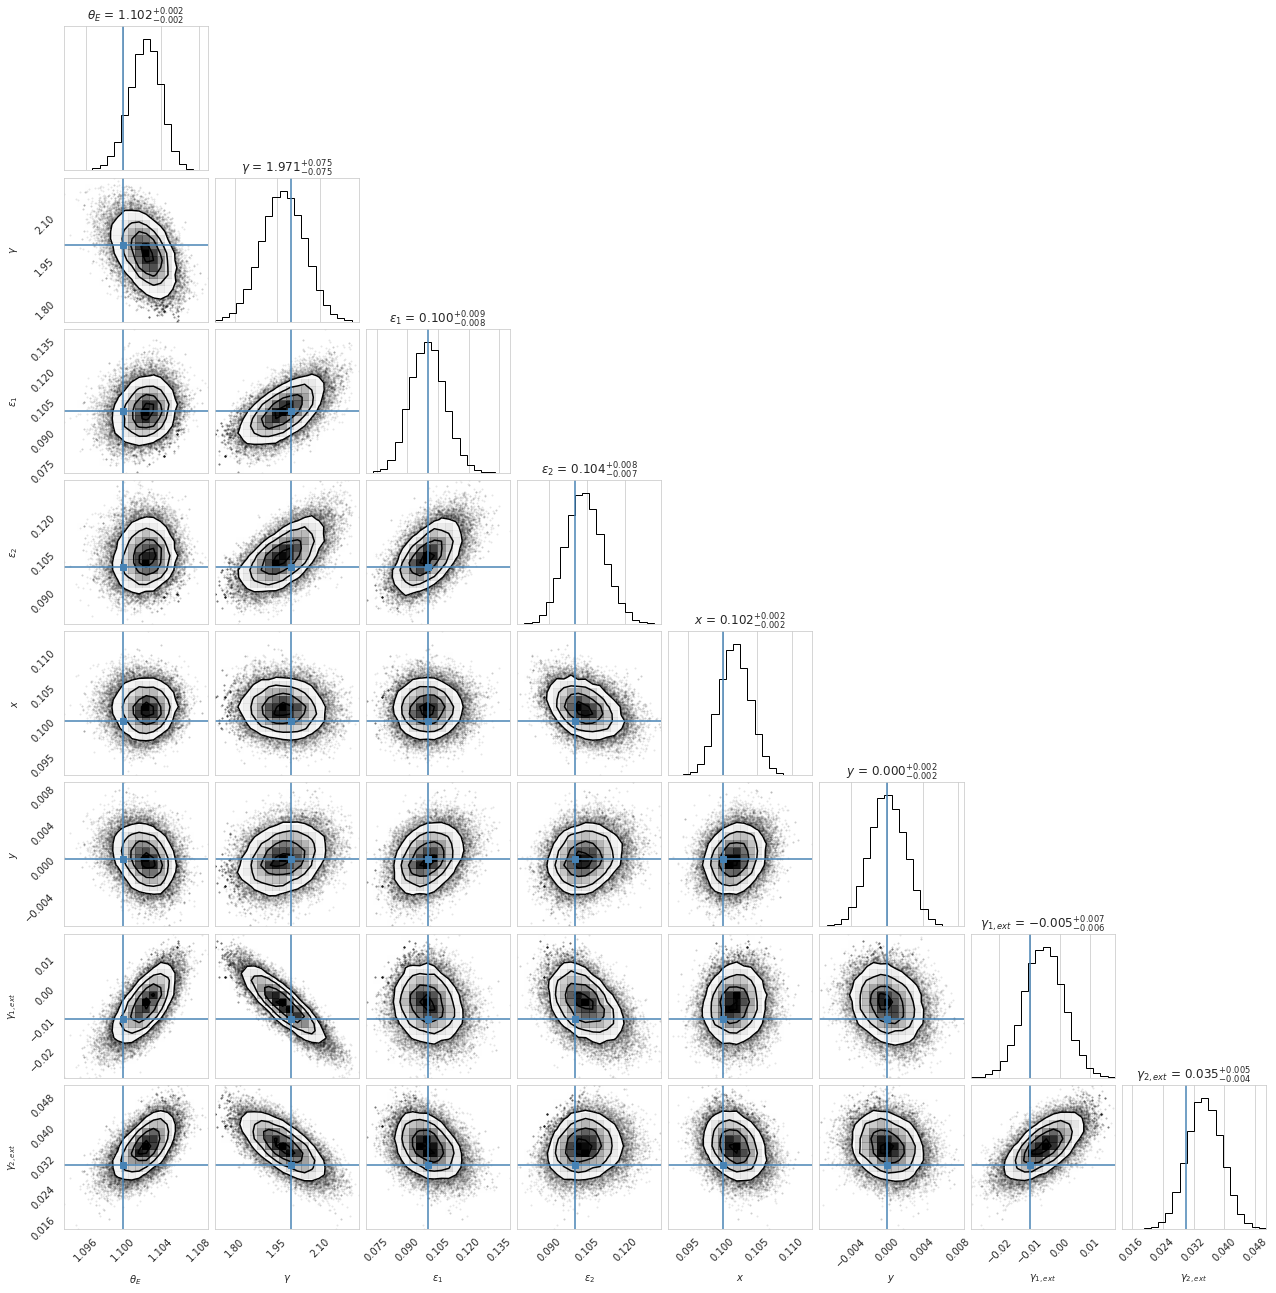

In [25]:
corner(tf.reshape(physical_samples, (-1,22))[:,:8].numpy(), truths=truth[:8], 
       show_titles=True, title_fmt='.3f',
       labels=[r'$\theta_E$', r'$\gamma$', r'$\epsilon_1$', r'$\epsilon_2$', r'$x$', r'$y$', r'$\gamma_{1,ext}$', r'$\gamma_{2,ext}$']);